In [ ]:
!pip install pyquaternion
!pip install --user --upgrade pixiedust

In [1]:
from itertools import starmap
from pyquaternion import Quaternion 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib
from sklearn.preprocessing import OneHotEncoder

from pylab import *
import pandas as pd

np.random.seed=1
%matplotlib inline

import pixiedust

Pixiedust database opened successfully


In [2]:
def addSuffix(l, suffix):
    return [i + suffix for i in l]
    
def toEulerianAngle(q):
    ysqr = q[2] * q[2]

    t0 = +2.0 * (q[0] * q[1] + q[2] * q[3])
    t1 = +1.0 - 2.0 * (q[1] * q[1] + ysqr)
    roll = np.arctan2(t0, t1)

    t2 = +2.0 * (q[0] * q[2] - q[3] * q[1])
    t2 = 1.0 if t2 > 1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch = np.arcsin(t2)

    t3 = +2.0 * (q[0] * q[3] + q[1] * q[2])
    t4 = +1.0 - 2.0 * (ysqr + q[3] * q[3])
    yaw = np.arctan2(t3, t4)

    return np.array([roll, pitch, yaw])


def getRollPitchYaw(q):
    return toEulerianAngle(q)


def eulerToQuaternion(roll, pitch, yaw):
    quaternion = [0] * 4
    cosPhi_2 = np.cos(roll / 2)
    sinPhi_2 = np.sin(roll / 2)
    cosTheta_2 = np.cos(pitch / 2)
    sinTheta_2 = np.sin(pitch / 2)
    cosPsi_2 = np.cos(yaw / 2)
    sinPsi_2 = np.sin(yaw / 2)

    quaternion[0] = (cosPhi_2 * cosTheta_2 * cosPsi_2 +
                     sinPhi_2 * sinTheta_2 * sinPsi_2)
    quaternion[1] = (sinPhi_2 * cosTheta_2 * cosPsi_2 -
                     cosPhi_2 * sinTheta_2 * sinPsi_2)
    quaternion[2] = (cosPhi_2 * sinTheta_2 * cosPsi_2 +
                     sinPhi_2 * cosTheta_2 * sinPsi_2)
    quaternion[3] = (cosPhi_2 * cosTheta_2 * sinPsi_2 -
                     sinPhi_2 * sinTheta_2 * cosPsi_2)

    return Quaternion(quaternion)


def transformToEarthFrame(vector, q):
    q_ = Quaternion(q)
    return q_.inverse.rotate(vector)


def transformToBodyFrame(vector, q):
    q_ = Quaternion(q)
    return q_.rotate(vector)


def generateGaussianNoise(std, mean=0):
    return np.random.normal(scale=std, loc=mean)


def wrapAroundPi(angle):
    return np.arctan2(np.sin(angle), np.cos(angle))


def integrateOrientation(euler, angularVelocity, f):
    return np.array(list(map(wrapAroundPi, euler + angularVelocity / f)))


def integratePosition(p0, v, f):
    return p0 + v / f


def getAverageAngularVelocity(p1, p0, f):
    return np.array(list(map(wrapAroundPi, p1 - p0))) * f


def getAverageLinearVelocity(p1, p0, f):
    return np.array((p1 - p0) * f)


def integrateTrajectory(initialPosition, initialOrientation, linearVelocitiesBody, angularVelocities, frequency):
    for v, w, f in zip(linearVelocitiesBody, angularVelocities, frequency):
        initialOrientation = integrateOrientation(initialOrientation, w, f)
        initialPosition = integratePosition(initialPosition,
                                            transformToEarthFrame(v, eulerToQuaternion(*initialOrientation)), f)
        yield initialPosition

In [3]:
path1 = 'C:/Users/talaa/Desktop/10hz.csv'
dataset = pd.read_csv(path1)

f = dataset['f'].values
position = ['x', 'y', 'z']
orientation = ['psi', 'theta', 'phi']
quaternion = ['scalar', 'i', 'j', 'k']

initialPositions = dataset[addSuffix(position, '0')].values
nextPositions = dataset[addSuffix(position, '1')].values
quaternions = dataset[addSuffix(quaternion, '1')].values

initialOrientations = dataset[addSuffix(orientation, '0')].values
nextOrientations = dataset[addSuffix(orientation, '1')].values

vEarth_avg = np.array(list(starmap(getAverageLinearVelocity, zip(nextPositions, initialPositions, f))))
vBody_avg = np.array(list(starmap(transformToBodyFrame, zip(vEarth_avg, quaternions))))
angularVelocities_avg = np.array(list(starmap(getAverageAngularVelocity, zip(nextOrientations, initialOrientations, f))))

for i, item in enumerate(zip(['dXB1_avg', 'dYB1_avg', 'dZB1_avg'], ['dPsi1_avg', 'dTheta1_avg', 'dPhi1_avg'])):
    v, w = item
    dataset[v] = vBody_avg[:, i]
    dataset[w] = angularVelocities_avg[:, i]
    
for i, item in enumerate(zip(['dXB0_avg', 'dYB0_avg', 'dZB0_avg'], ['dPsi0_avg', 'dTheta0_avg', 'dPhi0_avg'])):
    v, w = item
    dataset[v] = np.roll(vBody_avg[:, i], shift=1)
    dataset[w] = np.roll(angularVelocities_avg[:, i], shift=1)
    
dataset.drop(dataset.head(500).index, inplace=True)
dataset = dataset.reset_index(drop=True)

In [32]:
d = pd.get_dummies(dataset['aIndex'])
for i, item in enumerate(d.columns):
    dataset['a'+ str(i)] = d[item]

In [4]:
#modelInputs = ['dXB0_avg', 'dYB0_avg', 'dZB0_avg', 'dPsi0_avg', 'dTheta0_avg', 'dPhi0_avg'] + ['psi0', 'theta0'] +\
#              ['a0', 'a1', 'a2', 'a3']
modelInputs = ['dXB0_avg', 'dYB0_avg', 'dZB0_avg', 'dPsi0_avg', 'dTheta0_avg', 'dPhi0_avg'] + ['psi0', 'theta0'] +\
              ['aIndex']
modelOutputs = ['dXB1_avg', 'dYB1_avg', 'dZB1_avg', 'dPsi1_avg', 'dTheta1_avg', 'dPhi1_avg']

X, y = dataset[modelInputs], dataset[modelOutputs]
xTrain, xTest, yTrain, yTest =\
train_test_split(X, y, test_size=0.20, random_state=1)

In [5]:
X.head()

,dXB0_avg,dYB0_avg,dZB0_avg,dPsi0_avg,dTheta0_avg,dPhi0_avg,psi0,theta0,aIndex
0,-2.536448,-1.567901,-0.260986,-0.177838,-0.683673,0.097623,0.004212,0.040487,6
1,-2.508077,-1.686923,-0.344452,-0.036831,-0.377730,0.414181,0.000556,0.002992,6
2,-2.323330,-1.796243,-0.267099,-0.004745,-0.030309,0.672753,0.000087,-0.000001,6
3,-2.198226,-2.026094,-0.205442,-0.001123,-0.003253,0.869919,-0.000025,-0.000326,6
4,-1.932140,-2.158211,-0.157042,-0.000262,0.000137,0.964653,-0.000051,-0.000312,6


In [6]:
y.head()

,dXB1_avg,dYB1_avg,dZB1_avg,dPsi1_avg,dTheta1_avg,dPhi1_avg
0,-2.508077,-1.686923,-0.344452,-0.036831,-0.377730,0.414181
1,-2.323330,-1.796243,-0.267099,-0.004745,-0.030309,0.672753
2,-2.198226,-2.026094,-0.205442,-0.001123,-0.003253,0.869919
3,-1.932140,-2.158211,-0.157042,-0.000262,0.000137,0.964653
4,-1.746621,-2.414271,-0.129386,-0.000255,0.000175,1.044579


In [7]:
cvModel = MLPRegressor(max_iter=int(10e3), random_state=10)
parameters = {'hidden_layer_sizes':[(5, ), (10, ), (15, ), (25, )], 'alpha':[1e-4 * np.exp(i) for i in range(18)]}
clf = GridSearchCV(cvModel, parameters, n_jobs=-1)
clf.fit(xTrain, yTrain)

GridSearchCV(cv=None, error_score='raise',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=10, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(5,), (10,), (15,), (25,)], 'alpha': [0.0001, 0.00027182818284590454, 0.00073890560989306507, 0.0020085536923187667, 0.0054598150033144241, 0.01484131591025766, 0.040342879349273511, 0.10966331584284586, 0.29809579870417285, 0.81030839275753841, 2.202646579480672, 5.9874141715197817, 16.275479141900391, 44.24133920089205, 120.26042841647768, 326.90173724721109, 888.61105205078729, 2415.4952753575299]},
       pre_disp


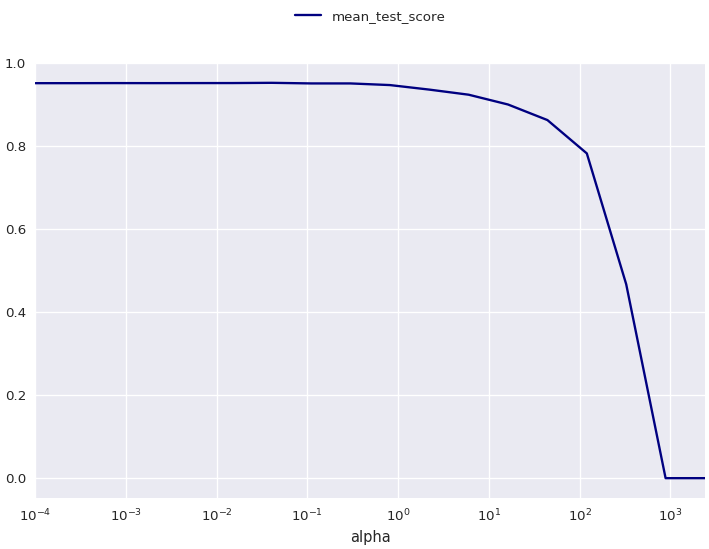

In [47]:
display(pd.DataFrame(list(zip(clf.cv_results_['param_alpha'],\
                              clf.cv_results_['mean_test_score'])), columns=['alpha', 'mean_test_score']))


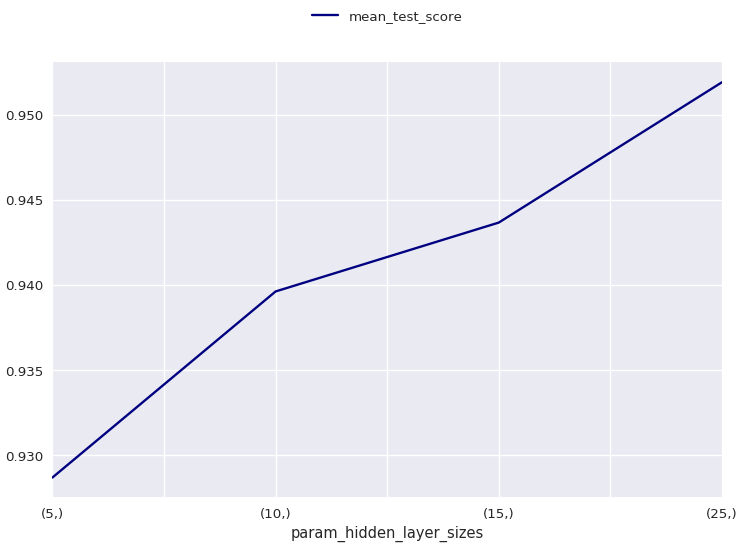

In [48]:
display(pd.DataFrame(list(zip(clf.cv_results_['param_hidden_layer_sizes'],\
                              clf.cv_results_['mean_test_score'])), columns=['param_hidden_layer_sizes', 'mean_test_score']))

In [33]:
print(clf.best_params_['alpha'], clf.best_params_['hidden_layer_sizes'])

0.0403428793493 (25,)


In [8]:
bestModel = MLPRegressor(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
                         alpha=clf.best_params_['alpha'], max_iter=int(10e8), random_state=10).fit(xTrain, yTrain)

means, stds= pd.DataFrame(bestModel.predict(xTest) - yTest, columns=y.columns).mean().values,\
             pd.DataFrame(bestModel.predict(xTest) - yTest, columns=y.columns).std().values

print(means, stds)

[ 0.00447392 -0.00290952 -0.00796779 -0.0089911   0.01437089 -0.00323888] [ 0.12626311  0.13530322  0.13689754  0.21184915  0.40904121  0.10195814]


In [9]:
model = MLPRegressor(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
                     alpha=clf.best_params_['alpha'], max_iter=int(10e8), random_state=10).fit(X, y)

In [20]:
def predict(limit, dataset, f):
    #actions = X[['a0', 'a1', 'a2', 'a3']].values[:limit]
    actions = X['aIndex'].values[:limit]
    current_orientation = dataset.loc[0, addSuffix(orientation, '0')].values
    
    vBody, angularVelocity, euler = np.zeros((limit, 3)), np.zeros((limit, 3)), np.zeros((limit, 3))
    for index in range(limit):
        if index != 0:
            s0 = np.concatenate((prediction, current_orientation[:-1], [actions[index]]))
        else:
            s0 = X.iloc[0].values
        
        prediction = model.predict(s0.reshape(1, -1))[0]
        current_orientation = integrateOrientation(current_orientation, prediction[[3, 4, 5]], f)
        
        euler[index] = current_orientation
        vBody[index] = prediction[[0, 1, 2]]
        angularVelocity[index] = prediction[[3, 4, 5]]
    
    return vBody, angularVelocity, euler

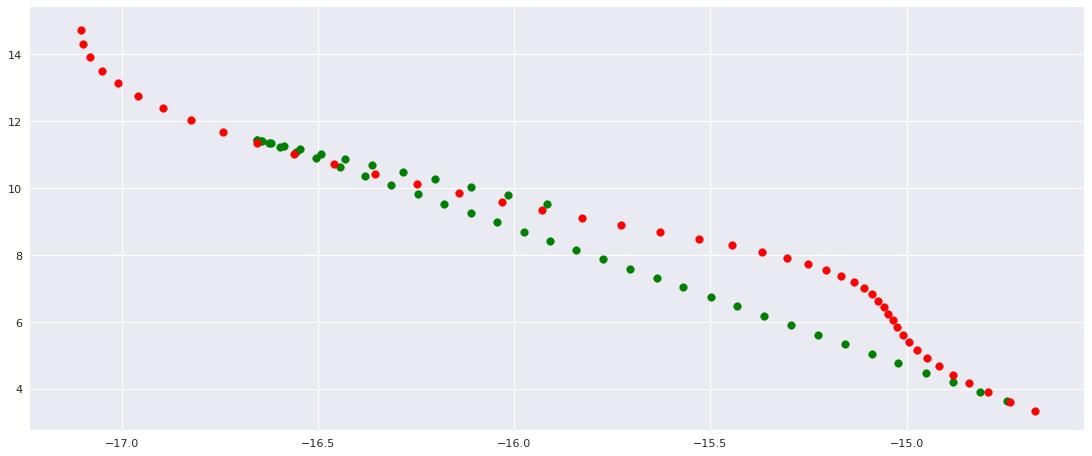

In [27]:
import warnings
warnings.filterwarnings("ignore")

limit=5000
figure(num=None, figsize=(17, 7), dpi=80, facecolor='w', edgecolor='k')
vBody, w, euler = predict(limit=limit, dataset=dataset, f=10)
gen = integrateTrajectory(dataset.loc[0, addSuffix(position , '0')].values, 
                          dataset.loc[0, addSuffix(orientation , '0')].values, vBody, w, f)

positions = np.zeros((limit, 3))
for i in range(45):
    p = next(gen)
    positions[i] = p
    plt.scatter(p[0], p[1], color='red')
    plt.scatter(dataset.loc[i, ['x1']].values, dataset.loc[i, ['y1']].values, color='green') 

In [24]:
np.sum(np.rad2deg(list(map(lambda x: wrapAroundPi(x), w[:25]-dataset[['dPsi1', 'dTheta1', 'dPhi1']].values[:25]))))/10.0

-76.522703635074762


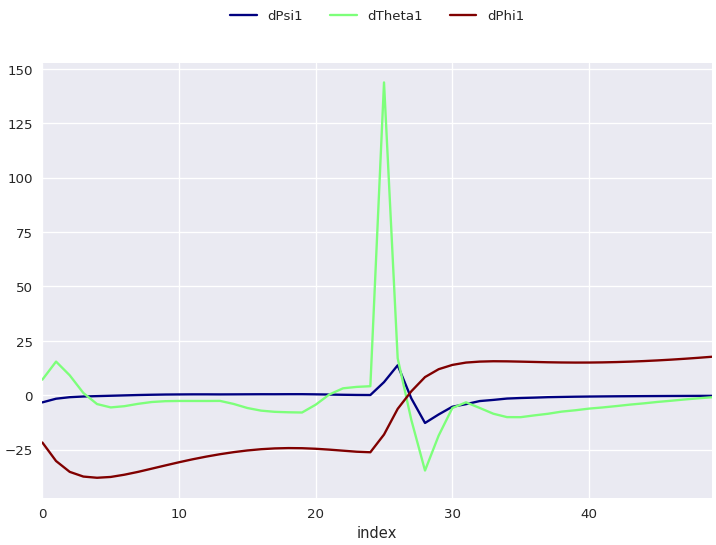

In [25]:
wError = pd.DataFrame(np.rad2deg(list(map(lambda x: wrapAroundPi(x),
                                          w-dataset[['dPsi1', 'dTheta1', 'dPhi1']].values[:limit]))),
                      columns=['dPsi1', 'dTheta1', 'dPhi1'])
wError['index'] = wError.index
display(wError[:50])


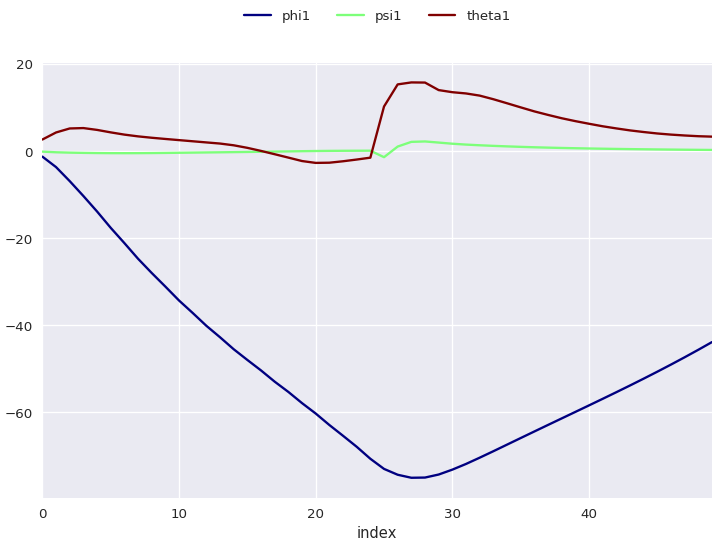

In [23]:
orientationError = pd.DataFrame(np.rad2deg(list(map(lambda x: wrapAroundPi(x),
                                                    euler-dataset[['psi1', 'theta1', 'phi1']].values[:5000]))),
                                columns=['psi1', 'theta1', 'phi1'])
orientationError['index'] = orientationError.index
display(orientationError[:50])


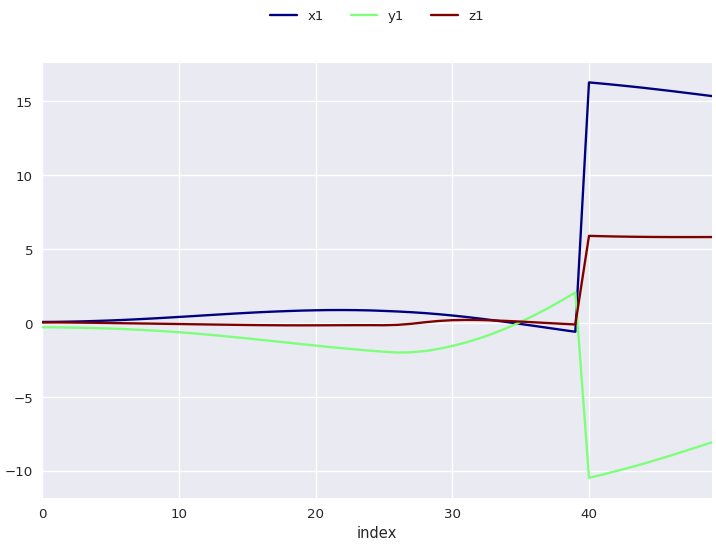

In [26]:
positionError = pd.DataFrame(positions-dataset[['x1', 'y1', 'z1']].values[:limit], columns=['x1', 'y1', 'z1'])
positionError['index'] = positionError.index
display(positionError[:50])

In [28]:
joblib.dump(model, 'C:/Users/talaa/PycharmProjects/rl/src/neuralModel.model')

['C:/Users/talaa/PycharmProjects/rl/src/neuralModel.model']